In [12]:
import matplotlib.pyplot as plt

In [39]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch.utils.data import random_split
import torch
from torchvision.models import resnet18,vgg16
from torch import nn, optim


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device:", device)
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

root_dir = "./Images/"


Using MPS device: mps


In [2]:
class TiffDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for class_label in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_label)
            if os.path.isdir(class_path):  
                for image_name in os.listdir(class_path):
                    if image_name.endswith(".tif"):
                        image_path = os.path.join(class_path, image_name)
                        self.data.append([image_path, class_label])

        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(set(label for _, label in self.data)))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, class_label = self.data[idx]
        image = Image.open(image_path).convert("RGB") 
        label = self.class_to_idx[class_label]

        if self.transform:
            image = self.transform(image)

        return image, label



In [3]:

def get_dataset(root_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    ])

    # Create dataset and dataloader
    dataset = TiffDataset(root_dir, transform=transform)
    return dataset

In [4]:
import random
def introduce_label_noise(subset, original_dataset, noise_level):

    targets = original_dataset.data
    subset_indices = subset.indices  

    num_noisy = int(noise_level * len(subset))
    noisy_indices = random.sample(subset_indices, num_noisy)

    for idx in noisy_indices:
        current_label = targets[idx][1]
        possible_labels = list(original_dataset.class_to_idx.keys())
        possible_labels.remove(current_label)
        targets[idx][1] = random.choice(possible_labels)

    return subset

In [5]:
def train_model(model,train_loader,val_loader,criterion,optimizer,train_dataset,num_epochs):
    max_acc = 0
    min_loss = 100
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        
        for images, labels in train_loader:  
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataset):.4f}")

        model.eval()  
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  
            for images, labels in val_loader:  
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        print(f"Validation Loss: {validation_loss / len(val_loader):.4f}, Accuracy: {acc:.2f}%")

        max_acc = max(max_acc,acc)
        min_loss = min(running_loss / len(train_dataset),min_loss)
    return max_acc,min_loss

In [46]:
def plot(noise_levels,values,title,model):
    plt.plot(noise_levels,values)
    plt.xlabel("Noise Level")
    plt.ylabel(title)
    plt.title(f"{title} vs. Noise Level")
    plt.legend()
    plt.savefig(f'{title}_{model}')
    plt.show()


In [6]:
resnet_stats = {}
noise_levels  = [0.01,0.05,0.1,0.2,0.4,0.6,0.9,1]
for noise_level in noise_levels:
    dataset = get_dataset(root_dir)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataset = introduce_label_noise(train_dataset, dataset, noise_level=noise_level)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(dataset.class_to_idx))  

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model = model.to(device)
    num_epochs = 10
    acc, loss  = train_model(model,train_loader,val_loader,criterion,optimizer,train_dataset,num_epochs)
    resnet_stats[str(noise_level)] = [acc,loss]

/Users/kash/.local/share/virtualenvs/AIL862-I6XuGHb-/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kash/.local/share/virtualenvs/AIL862-I6XuGHb-/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0249
Validation Loss: 0.4615, Accuracy: 90.95%
Epoch [2/10], Loss: 0.0045
Validation Loss: 0.1999, Accuracy: 96.67%
Epoch [3/10], Loss: 0.0018
Validation Loss: 0.1568, Accuracy: 97.62%
Epoch [4/10], Loss: 0.0011
Validation Loss: 0.1248, Accuracy: 97.86%
Epoch [5/10], Loss: 0.0007
Validation Loss: 0.1199, Accuracy: 98.10%
Epoch [6/10], Loss: 0.0006
Validation Loss: 0.1088, Accuracy: 98.10%
Epoch [7/10], Loss: 0.0004
Validation Loss: 0.1008, Accuracy: 98.10%
Epoch [8/10], Loss: 0.0004
Validation Loss: 0.0977, Accuracy: 98.10%
Epoch [9/10], Loss: 0.0003
Validation Loss: 0.0950, Accuracy: 98.33%
Epoch [10/10], Loss: 0.0002
Validation Loss: 0.1312, Accuracy: 96.19%
Epoch [1/10], Loss: 0.0271
Validation Loss: 0.5116, Accuracy: 90.71%
Epoch [2/10], Loss: 0.0079
Validation Loss: 0.2587, Accuracy: 95.95%
Epoch [3/10], Loss: 0.0042
Validation Loss: 0.2187, Accuracy: 97.14%
Epoch [4/10], Loss: 0.0026
Validation Loss: 0.1874, Accuracy: 97.62%
Epoch [5/10], Loss: 0.0017
Valida

In [37]:
accuracies = [acc for acc,loss in resnet_stats.values()]
losses = [loss for acc,loss in resnet_stats.values()]

/tmp/ipykernel_43897/3273158815.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


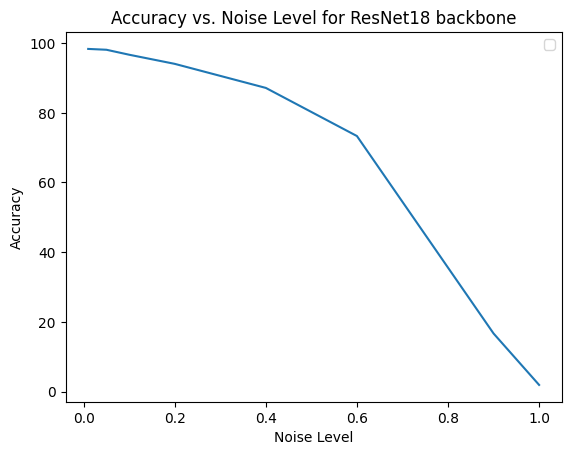

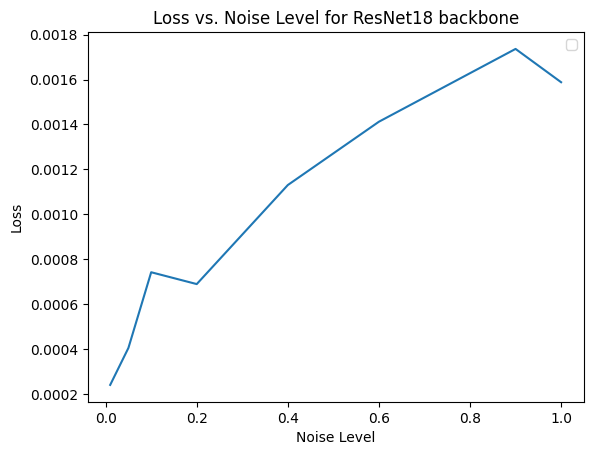

In [38]:
plot(noise_levels,accuracies,'Accuracy','ResNet18')
plot(noise_levels,losses,'Loss','ResNet18')

In [43]:
vgg_stat = {}
for noise_level in [0.1,0.2,0.4,0.6,0.9,1]:
    dataset = get_dataset(root_dir)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataset = introduce_label_noise(train_dataset, dataset, noise_level=noise_level)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(dataset.class_to_idx))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model = model.to(device)
    num_epochs = 5
    acc, loss  = train_model(model,train_loader,val_loader,criterion,optimizer,train_dataset,num_epochs)
    vgg_stat[str(noise_level)] = [acc,loss]

/Users/kash/.local/share/virtualenvs/AIL862-I6XuGHb-/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kash/.local/share/virtualenvs/AIL862-I6XuGHb-/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.0606
Validation Loss: 0.6274, Accuracy: 81.67%
Epoch [2/5], Loss: 0.0326
Validation Loss: 0.4783, Accuracy: 85.48%
Epoch [3/5], Loss: 0.0222
Validation Loss: 0.3130, Accuracy: 90.95%
Epoch [4/5], Loss: 0.0148
Validation Loss: 0.2972, Accuracy: 91.19%
Epoch [5/5], Loss: 0.0091
Validation Loss: 0.2768, Accuracy: 91.19%
Epoch [1/5], Loss: 0.0714
Validation Loss: 1.1008, Accuracy: 70.00%
Epoch [2/5], Loss: 0.0489
Validation Loss: 0.7611, Accuracy: 82.38%
Epoch [3/5], Loss: 0.0369
Validation Loss: 0.5375, Accuracy: 87.14%
Epoch [4/5], Loss: 0.0273
Validation Loss: 0.4206, Accuracy: 90.24%
Epoch [5/5], Loss: 0.0205
Validation Loss: 0.5551, Accuracy: 83.81%
Epoch [1/5], Loss: 0.0881
Validation Loss: 2.0366, Accuracy: 51.43%
Epoch [2/5], Loss: 0.0747
Validation Loss: 1.3364, Accuracy: 70.71%
Epoch [3/5], Loss: 0.0652
Validation Loss: 1.2674, Accuracy: 78.81%
Epoch [4/5], Loss: 0.0548
Validation Loss: 1.2260, Accuracy: 73.81%
Epoch [5/5], Loss: 0.0450
Validation Loss: 1.113

In [44]:
vgg_stat

{'0.01': [94.04761904761905, 0.000741180079750761],
 '0.05': [94.52380952380952, 0.000668366222470511],
 '0.1': [91.19047619047619, 0.00911942523283263],
 '0.2': [90.23809523809524, 0.02050937677600554],
 '0.4': [78.80952380952381, 0.04496583278690066],
 '0.6': [71.66666666666667, 0.07811052586351122],
 '0.9': [8.333333333333334, 0.09551153097833906],
 '1': [4.523809523809524, 0.09538205663363139]}

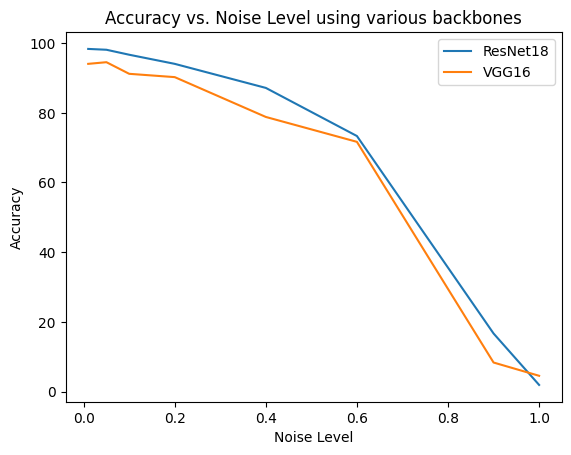

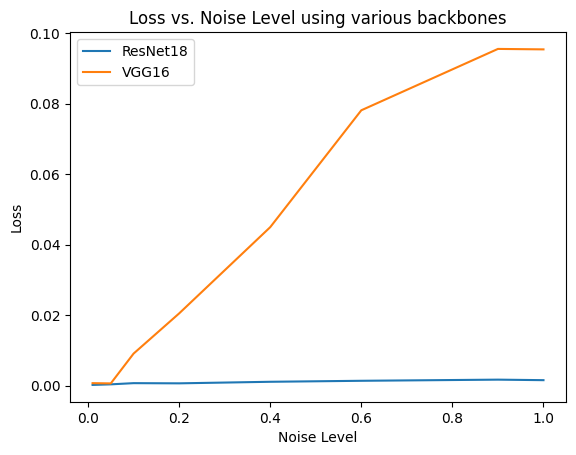

In [47]:
vgg_accuracies = [acc for acc,loss in vgg_stat.values()]
vgg_losses = [loss for acc,loss in vgg_stat.values()]
plot(noise_levels,vgg_accuracies,'Accuracy','VGG16')
plot(noise_levels,vgg_losses,'Loss','VGG16')

In [49]:
losses

[0.00024022742983929459,
 0.00040494297143249286,
 0.0007420012073236562,
 0.0006892590040695809,
 0.0011303966909292197,
 0.0014123105554885807,
 0.0017364930494555406,
 0.0015881978995388461]

In [50]:
vgg_losses

[0.000741180079750761,
 0.000668366222470511,
 0.00911942523283263,
 0.02050937677600554,
 0.04496583278690066,
 0.07811052586351122,
 0.09551153097833906,
 0.09538205663363139]